# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1320s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1582, 32, 20, 3)
(1582, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
396/396 [==============================] - 5s 12ms/step - loss: 2.2744 - accuracy: 0.2838
Epoch 2/500
396/396 [==============================] - 5s 12ms/step - loss: 1.5203 - accuracy: 0.5381
Epoch 3/500
396/396 [==============================] - 5s 13ms/step - loss: 1.0391 - accuracy: 0.6685
Epoch 4/500
396/396 [==============================] - 5s 13ms/step - loss: 0.8067 - accuracy: 0.7424
Epoch 5/500
396/396 [==============================] - 6s 15ms/step - loss: 0.7404 - accuracy: 0.7828
Epoch 6/500
396/396 [==============================] - 5s 13ms/step - loss: 0.6117 - accuracy: 0.8173
Epoch 7/500
396/396 [==============================] - 6s 14ms/step - loss: 0.5233 - accuracy: 0.8246
Epoch 8/500
396/396 [==============================] - 5s 13ms/step - loss: 0.5407 - accuracy: 0.8390
Epoch 9/500
396/396 [==============================] - 5s 13ms/step - loss: 0.5501 - accuracy: 0.8270
Epoch 10/500
396/396 [==============================] - 5s 13ms/step - loss: 0.395

396/396 [==============================] - 5s 13ms/step - loss: 0.0778 - accuracy: 0.9720 2s - los
Epoch 153/500
396/396 [==============================] - 5s 12ms/step - loss: 0.1136 - accuracy: 0.9717 4s - loss: 0.2072 - ac - ETA: 3s - loss: 0.187 - ETA: 3s - ETA: 
Epoch 154/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0860 - accuracy: 0.9765
Epoch 155/500
396/396 [==============================] - 5s 13ms/step - loss: 0.1014 - accuracy: 0.9705 1s - loss: 0.1077 - accuracy: 0. - ETA: 1s - loss: - ETA: 0s - loss: 0.1
Epoch 156/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0780 - accuracy: 0.9801 0s - loss: 0
Epoch 157/500
396/396 [==============================] - 5s 13ms/step - loss: 0.0910 - accuracy: 0.9748
Epoch 158/500
396/396 [==============================] - 5s 13ms/step - loss: 0.1203 - accuracy: 0.9730 0s - loss: 0.1205 - accuracy: 0.97
Epoch 159/500
396/396 [==============================] - 5s 13ms/step - loss: 0.0624 - accu

396/396 [==============================] - 5s 12ms/step - loss: 0.0524 - accuracy: 0.9837 1s - los - ETA: 0s - loss:
Epoch 260/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0422 - accuracy: 0.9879
Epoch 261/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0420 - accuracy: 0.9901
Epoch 262/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0599 - accuracy: 0.9834
Epoch 263/500
396/396 [==============================] - 5s 13ms/step - loss: 0.0457 - accuracy: 0.9871 0s - loss: 0.0451 - accuracy
Epoch 264/500
396/396 [==============================] - 5s 13ms/step - loss: 0.1004 - accuracy: 0.9753
Epoch 289/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0384 - accuracy: 0.9911
Epoch 290/500
396/396 [==============================] - 5s 12ms/step - loss: 0.0879 - accuracy: 0.9768
Epoch 291/500
396/396 [==============================] - 5s 12ms/step - loss: 0.1054 - accuracy: 0.9817
Epoch 292/500
396/396 

396/396 [==============================] - 4s 10ms/step - loss: 0.0406 - accuracy: 0.9863
Epoch 440/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0202 - accuracy: 0.9930 0s - loss:
Epoch 441/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0496 - accuracy: 0.9878
Epoch 442/500
396/396 [==============================] - 4s 10ms/step - loss: 0.0256 - accuracy: 0.9940
Epoch 443/500
396/396 [==============================] - 3s 8ms/step - loss: 0.0719 - accuracy: 0.9863
Epoch 444/500
396/396 [==============================] - 3s 8ms/step - loss: 0.0550 - accuracy: 0.9859
Epoch 445/500
396/396 [==============================] - 3s 8ms/step - loss: 0.0628 - accuracy: 0.9851: 0s - loss: 0
Epoch 446/500
396/396 [==============================] - 3s 8ms/step - loss: 0.0482 - accuracy: 0.9876
Epoch 447/500
396/396 [==============================] - 3s 8ms/step - loss: 0.0485 - accuracy: 0.9870
Epoch 448/500
396/396 [==============================] - 3

### Learing result
 
* Visualization of the training and validation results

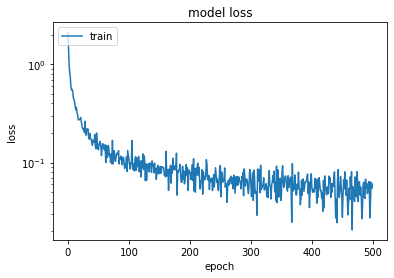

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\2_10_dig6_20210726-190157.jpg 2 -1


ziffer_sortiert_resize\2_10_dig6_20210727-130728.jpg 2 7


ziffer_sortiert_resize\2_4_nt7_20210625-210138.jpg 2 -1


ziffer_sortiert_resize\4_10_dig4_20210709-181251.jpg 4 -1


ziffer_sortiert_resize\4_4_dig6_20210724-184309.jpg 4 -1


ziffer_sortiert_resize\5_dig4_20210910-060143.jpg 5 9


ziffer_sortiert_resize\6_3_dig4_20210722-224727.jpg 6 9


ziffer_sortiert_resize\7_D6_2020-08-14_15-13-16.jpg 7 -1


ziffer_sortiert_resize\8_0_ht7_20210703-115549.jpg 8 0


ziffer_sortiert_resize\8_3_dig4_20210725-094630.jpg 8 0


ziffer_sortiert_resize\NaN_6_dig6_20210720-121946.jpg -1 9


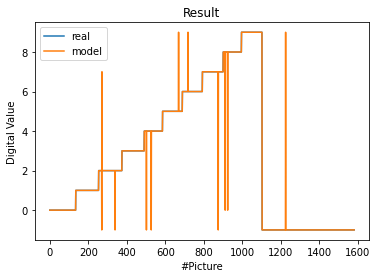

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpwx0mj07c\assets


1302912

In [1]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + "q" + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

NameError: name 'TFliteNamingAndVersion' is not defined

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.